In [1]:
import numpy as np
import copy
import re
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from hmmlearn import hmm
from itertools import chain
np.random.seed(42)
pd.options.display.max_rows = 20

In [2]:
%config InlineBackend.figure_format = 'png'

In [3]:
videos_true_length = []
videos = []
for i in range(1,28):
    steps = map(lambda x: x.strip().split("\t")[1], open("../annotations/workflow_video_%02d.txt" % i, "r").readlines()[1:])
    videos.append(steps[24::25]) # keep 1 frame out of 25
    videos_true_length.append(len(steps)) # keep 1 frame out of 25

In [4]:
unique_steps = list(reduce(lambda s1, s2: s1.union(s2), map(lambda s: set(s), videos)))

# Manual writting of steps to have meaningful order
ordered_unique_steps = \
    ["TrocarPlacement", "Preparation", "CalotTriangleDissection", "ClippingCutting", "GallbladderDissection",
     "GallbladderPackaging", "CleaningCoagulation", "GallbladderRetraction"]
p = len(ordered_unique_steps)

if len(set(ordered_unique_steps).difference(set(unique_steps))) > 0:
    raise Exception("Sets do not match")
else:
    print ordered_unique_steps

['TrocarPlacement', 'Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']


In [5]:
# This map will be used to get the index of a string step
step_index = {v: k for k, v in zip(range(p), ordered_unique_steps)}

### Computing transition / start statistics

Le'ts take a look at the transition statistics between each pair of steps and start probability

In [6]:
pi = np.zeros(p)

for steps in videos:
    pi[step_index[steps[0]]] += 1
pi /= len(videos)

print "pi:"
print pi

pi:
[ 1.  0.  0.  0.  0.  0.  0.  0.]


[[  9.94504376e-01   5.49562386e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.90228013e-01   9.77198697e-03   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.98417536e-01   1.58246395e-03
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.96450638e-01
    3.54936243e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    9.98397626e-01   1.18694362e-03   4.15430267e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   9.85381700e-01   9.20411478e-03   5.41418517e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   8.22368421e-04   9.97180451e-01   1.99718045e-03]
 [  0.0000000

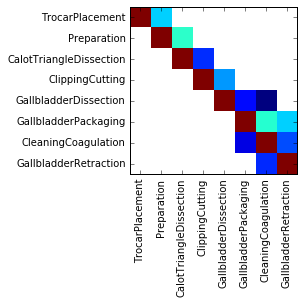

In [7]:
A = np.zeros((p,p))

for steps in videos:
    for (s1, s2) in zip(steps[0:-1], steps[1:]):
        A[step_index[s1], step_index[s2]] += 1

A /= np.sum(A, axis=1, keepdims=True)

print A
plt.figure(figsize=(3,3))
plt.imshow(np.log(A), interpolation="nearest")
plt.xticks(range(p),ordered_unique_steps, rotation=90)
plt.yticks(range(p),ordered_unique_steps)
plt.show()

### Load data

In [29]:
# Read train data for emission

def processEmissionTrain(l):
    data = l.strip().split(";")
    vidInfo = re.search(r"_([0-9]+)-([0-9]+)", data[0])
    return (int(vidInfo.group(1)) - 1, int(vidInfo.group(2)) -1, int(data[1]) - 1, map(float, data[3:]))

train_pred_seq = map(processEmissionTrain, open("../extract/finetuning_train/16_09_18_02:19:13_epoch,15/trainset.csv", "r").readlines()[1:])

In [30]:
def processEmissionTest(l):
    data = l.strip().split(";")
    vidInfo = re.search(r"_([0-9]+)-([0-9]+)", data[0])
    return (int(vidInfo.group(1)) - 1, int(vidInfo.group(2)) -1, map(float, data[1:]))

test_pred_seq = map(processEmissionTest, open("../extract/finetuning_train/16_09_18_02:19:13_epoch,15/testset.csv", "r").readlines()[1:])

In [31]:
test_pred_seq_df = pd.DataFrame(test_pred_seq, columns=["vid","frame", "probas"])
test_pred_seq_df

,vid,frame,probas
0,0,60,"[0.533911585808, -0.81691801548, -0.4335589706..."
1,0,61,"[0.540850639343, -0.814358413219, -0.425634294..."
2,0,62,"[0.536213338375, -0.817094802856, -0.432582855..."
3,0,63,"[0.533552527428, -0.816749930382, -0.428051680..."
4,0,64,"[0.543627023697, -0.820966482162, -0.430091172..."
5,0,65,"[0.540089130402, -0.824558436871, -0.446934401..."
6,0,66,"[0.536978840828, -0.820302724838, -0.442479461..."
7,0,67,"[0.532389104366, -0.816953897476, -0.434040486..."
8,0,68,"[0.538412153721, -0.823495745659, -0.423048406..."
9,0,69,"[0.531868517399, -0.816706001759, -0.434666663..."


In [32]:
test_pred_probas_ids = []
test_pred_probas = []

for vidId, group in test_pred_seq_df.groupby("vid"):
    group = group.sort("frame")
    
    test_pred_probas_ids.append(vidId)
    test_pred_probas.append(group["probas"].tolist())

### Computing emission statistics

In the HMM continuous gaussian model, for each hidden state, we emit an observed data vector based on a gaussian distribution. Let's compute mean and variance of these gaussians.

In [33]:
# Isolate probas generated for each class

probas_by_class = [[], [], [], [], [], [], [], []]

for el in train_pred_seq:
    probas_by_class[el[2]].append(el[3])

In [34]:
# Compute sigmas & mus

mus = np.zeros((p,p))
sigmas = np.zeros((p,p,p))

for i in range(p):
    X = np.array(probas_by_class[i])
    mus[i, :] = np.mean(X, axis=0)
    sigmas[i, :, :] = np.cov(X, rowvar=False)

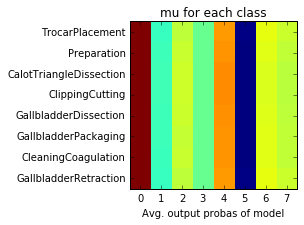

In [35]:
# Display mus

plt.figure(figsize=(3,3))
plt.imshow(mus, interpolation="nearest")
plt.title("mu for each class")
plt.yticks(range(p),ordered_unique_steps)
plt.xlabel("Avg. output probas of model")
plt.show()

## Applying the HMM

### Parameters

Set the models parameters with what we computed before

In [14]:
model = hmm.GaussianHMM(n_components=p, covariance_type="full")
model.startprob_ = pi
model.transmat_ = A
model.means_ = mus
model.covars_ = sigmas

### Sample

Generate a sample to check for weird behavior

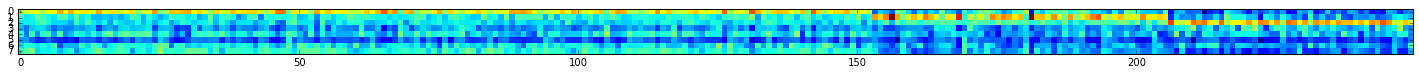

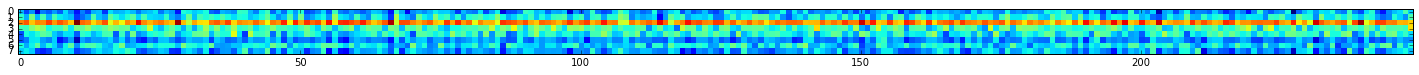

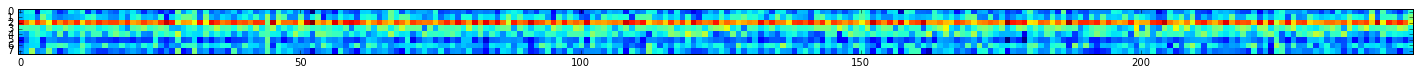

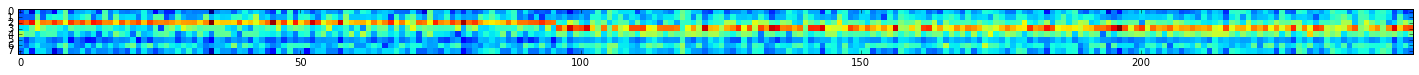

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [15]:
X, Z = model.sample(1000)
plt.figure(figsize=(25, 5))
plt.imshow(X[0:250, :].T, interpolation="nearest")
plt.show()
plt.figure(figsize=(25, 5))
plt.imshow(X[251:500, :].T, interpolation="nearest")
plt.show()
plt.figure(figsize=(25, 5))
plt.imshow(X[501:750, :].T, interpolation="nearest")
plt.show()
plt.figure(figsize=(25, 5))
plt.imshow(X[751:1000, :].T, interpolation="nearest")
plt.show()
print Z

### Decoding a sequence

In [65]:
videos_true_length_test = dict(
    map(lambda x: (int(x[0][-6:-4]) -1 , int(x[1])),
        map(lambda x: x.split("\t"), open("../dataset2/nb-frames.txt", "r").read().strip().split("\t\r\n"))
        )
    )

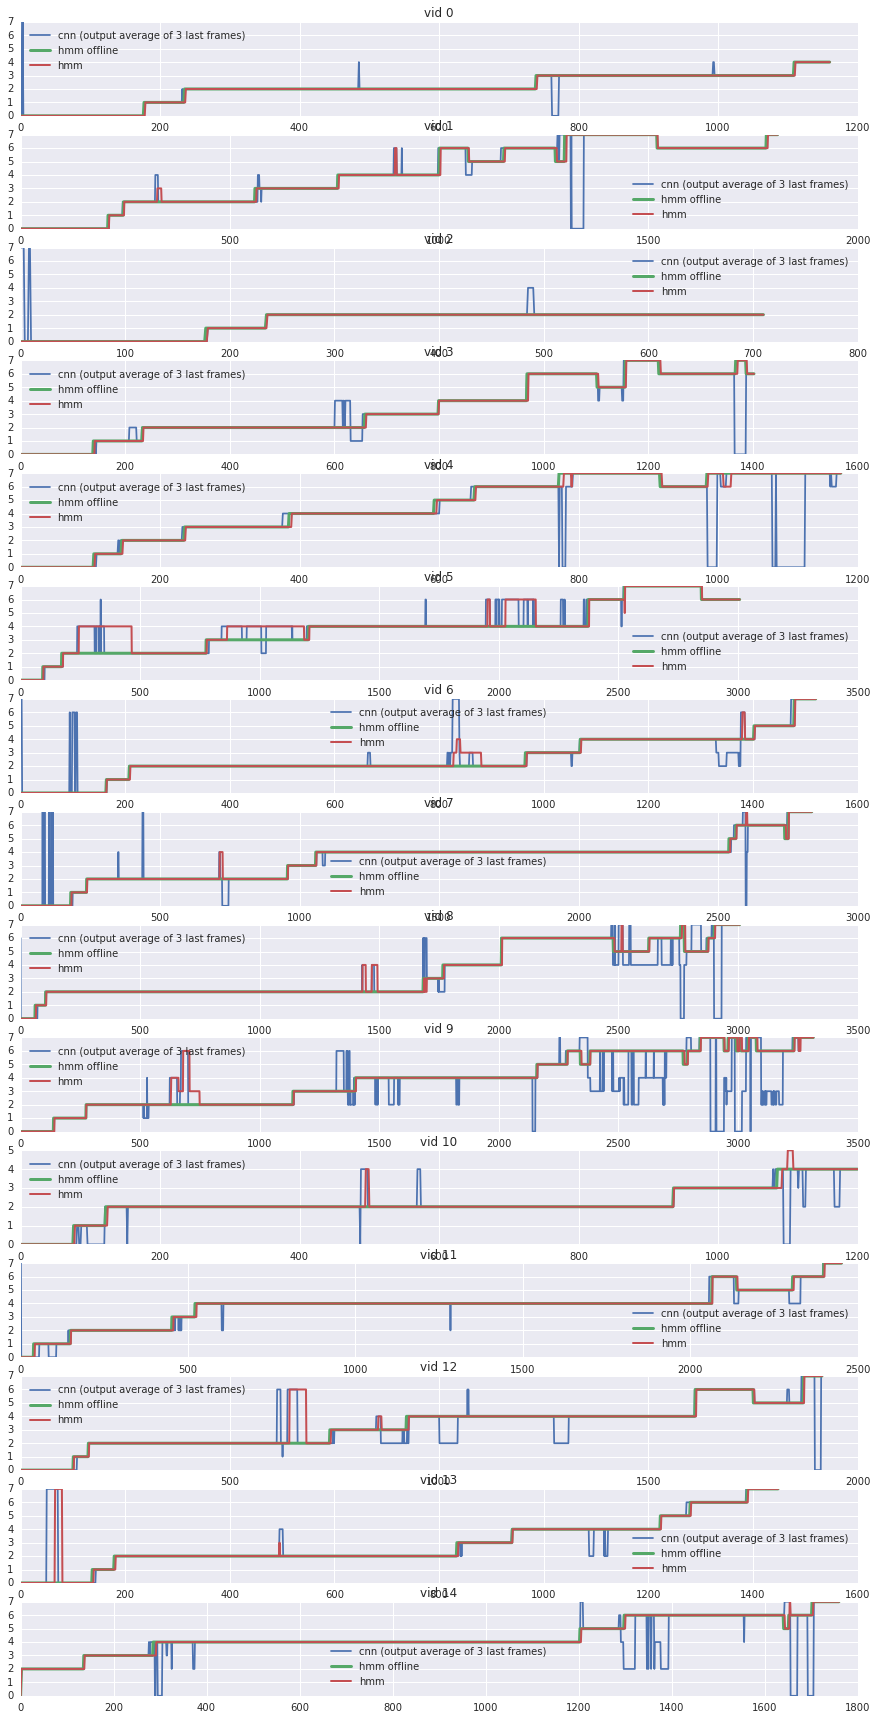

In [72]:
import seaborn

VAL = False
SAVE = True

plt.figure(figsize=(15,30))
for testInd in range(len(test_pred_probas_ids)):

    vidInd = test_pred_probas_ids[testInd]
    probas = np.array(test_pred_probas[testInd])
    
    if VAL:
        steps_gt = test_pred_probas_gt[testInd]
    
    # lissage
    #p = 5
    #ps2 = p/2 # auto floored
    #tmp = probas[ps2:-ps2] * 0
    #for i in range(p-1):
    #    tmp += probas[i:-p+i+1, :]
    #probas[ps2:-ps2] = (tmp + probas[p-1:, :]) / p
    for i in range(1,15):
        probas[i:] = (i * probas[i:] + probas[:-i]) / (i + 1)
    
    # pred
    steps_hat_cnn = np.argmax(np.array(probas), axis=1)
    (_, steps_hat_hmm_off) = model.decode(probas)
    steps_hat_hmm = np.array(steps_hat_cnn) * 0
    for i in range(len(probas)):
        (_, steps_hat_hmm_tmp) = model.decode(probas[:i+1])
        steps_hat_hmm[i] = steps_hat_hmm_tmp[-1]

    # plot
    title = "vid %d" % vidInd
    if VAL:
        title += ", cnn err. %.1f %%, " % (np.sum(np.array(steps_gt) != np.array(steps_hat_cnn)) * 100.0 / len(steps_gt))
        title += "hmm err. %.1f %%, " % (np.sum(np.array(steps_gt) != np.array(steps_hat_hmm)) * 100.0 / len(steps_gt))
        title += "hmm off err. %.1f %%" % (np.sum(np.array(steps_gt) != np.array(steps_hat_hmm_off)) * 100.0 / len(steps_gt))
    plt.subplot(len(test_pred_probas_ids),1,testInd+1)
    plt.title(title)
    plt.plot(range(len(steps_hat_cnn)), steps_hat_cnn, label="cnn (output average of 3 last frames)")
    if VAL:
        plt.plot(range(len(steps_gt)), steps_gt, lw=5, label="gt")
    plt.plot(range(len(steps_hat_hmm_off)), steps_hat_hmm_off, lw=3, label="hmm offline")
    plt.plot(range(len(steps_hat_hmm)), steps_hat_hmm, lw=2, label="hmm")
    #plt.xlim([0,2500])
    plt.legend(loc="best")
    
    # adjust length and save
    if VAL:
        targetLen = videos_true_length[vidInd]
    else:
        targetLen = videos_true_length_test[vidInd]
    
    steps_hat_cnn = list(chain(*zip(*[steps_hat_cnn for _ in range(25)])))
    steps_hat_hmm = list(chain(*zip(*[steps_hat_hmm for _ in range(25)])))
    steps_hat_hmm_off = list(chain(*zip(*[steps_hat_hmm_off for _ in range(25)])))
    
    steps_hat_cnn = steps_hat_cnn[0:targetLen] # crop if too long
    steps_hat_cnn += [steps_hat_cnn[-1]] * (targetLen - len(steps_hat_cnn)) # pad if too short
    
    steps_hat_hmm = steps_hat_hmm[0:targetLen] # crop if too long
    steps_hat_hmm += [steps_hat_hmm[-1]] * (targetLen - len(steps_hat_hmm)) # pad if too short
    
    steps_hat_hmm_off = steps_hat_hmm_off[0:targetLen] # crop if too long
    steps_hat_hmm_off += [steps_hat_hmm_off[-1]] * (targetLen - len(steps_hat_hmm_off)) # pad if too short
    
    if SAVE:
        f = open("../predictions/test_cnn/workflow_video_%02d_pred.txt" % (vidInd+1), "w")
        f.write("Frame\tPhase\n")
        for i, step in enumerate(steps_hat_cnn):
            f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
        f.close()

        f = open("../predictions/test_hmm/workflow_video_%02d_pred.txt" % (vidInd+1), "w")
        f.write("Frame\tPhase\n")
        for i, step in enumerate(steps_hat_hmm):
            f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
        f.close()
        
        f = open("../predictions/test_hmm_off/workflow_video_%02d_pred.txt" % (vidInd+1), "w")
        f.write("Frame\tPhase\n")
        for i, step in enumerate(steps_hat_hmm_off):
            f.write("%d\t%s\n" % (i, ordered_unique_steps[step]))
        f.close()
    
plt.show()